device: cpu
step     1 | mean tour len: 15.6245 | baseline(ema): 15.6245
step    50 | mean tour len: 20.9959 | baseline(ema): 20.9444
step   100 | mean tour len: 21.6372 | baseline(ema): 21.3497
step   150 | mean tour len: 21.5585 | baseline(ema): 21.4714
step   200 | mean tour len: 21.3397 | baseline(ema): 21.5751
step   250 | mean tour len: 21.2588 | baseline(ema): 21.4561
step   300 | mean tour len: 21.3500 | baseline(ema): 21.5365
step   350 | mean tour len: 21.5215 | baseline(ema): 21.5453
step   400 | mean tour len: 21.6056 | baseline(ema): 21.6110
step   450 | mean tour len: 21.5868 | baseline(ema): 21.6388
step   500 | mean tour len: 21.5440 | baseline(ema): 21.5194
step   550 | mean tour len: 21.6813 | baseline(ema): 21.6854
step   600 | mean tour len: 21.4628 | baseline(ema): 21.6173
step   650 | mean tour len: 21.7007 | baseline(ema): 21.6627
step   700 | mean tour len: 21.4593 | baseline(ema): 21.5848
step   750 | mean tour len: 21.6267 | baseline(ema): 21.6807
step   800 |

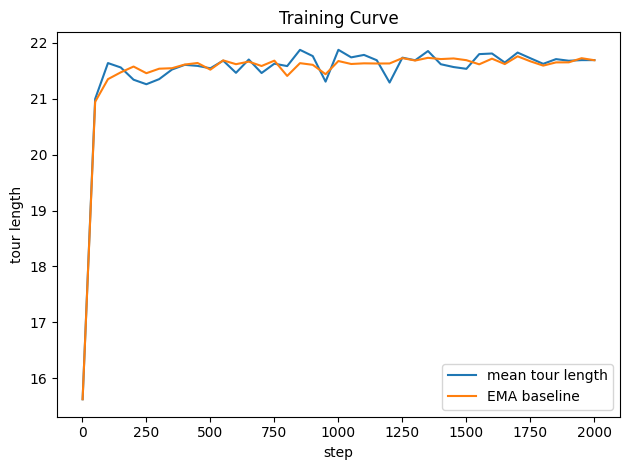

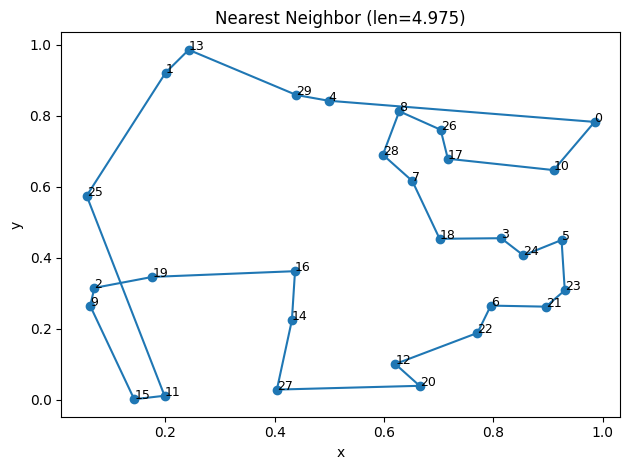

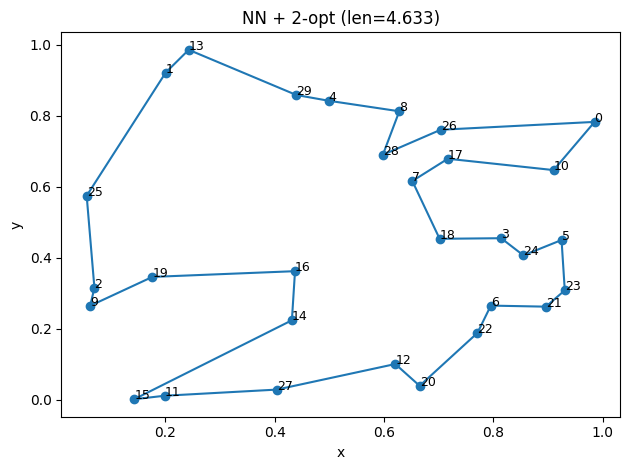

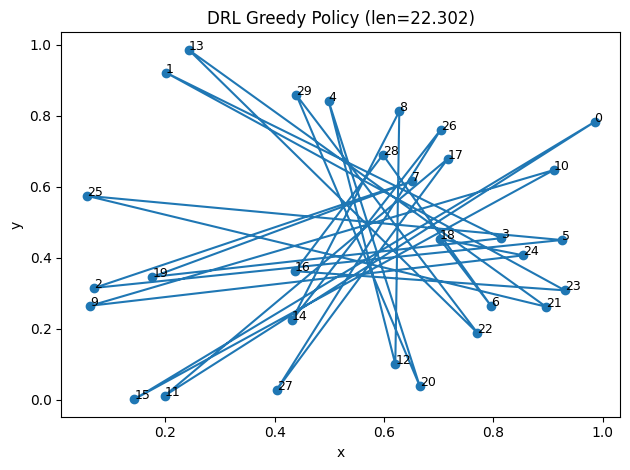

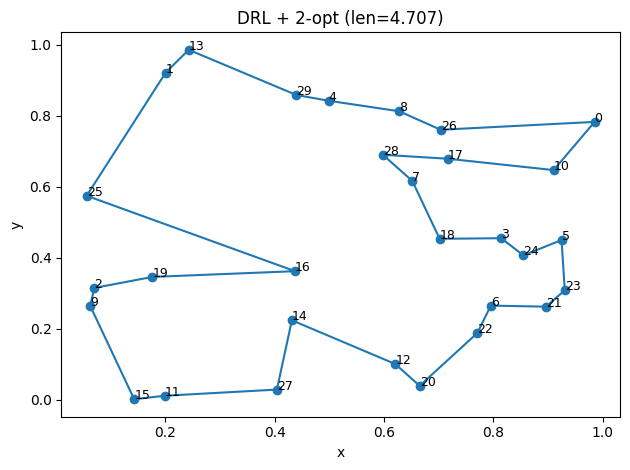

In [1]:
# drl_tsp_reinforce_with_plots_2opt_full.py
# DRL (REINFORCE) for Euclidean TSP + plots + 2-opt postprocessing
# pip install torch matplotlib

import math
import random
from dataclasses import dataclass
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# -----------------------------
# Utilities
# -----------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def tour_length(coords: torch.Tensor, tour: torch.Tensor) -> torch.Tensor:
    """
    coords: [B, N, 2]
    tour:   [B, N] (permutation indices)
    returns: [B]
    """
    B, N, _ = coords.shape
    idx = tour.unsqueeze(-1).expand(B, N, 2)
    ordered = coords.gather(1, idx)  # [B, N, 2]
    rolled = torch.roll(ordered, shifts=-1, dims=1)
    seg = (ordered - rolled).norm(dim=-1)  # [B, N]
    return seg.sum(dim=1)


def greedy_nearest_neighbor(coords: torch.Tensor) -> torch.Tensor:
    """
    Simple baseline: nearest neighbor tour, start at 0
    coords: [N, 2]
    returns tour: [N]
    """
    N = coords.size(0)
    dist = torch.cdist(coords, coords)  # [N, N]
    visited = torch.zeros(N, dtype=torch.bool)
    tour = []
    cur = 0
    visited[cur] = True
    tour.append(cur)
    for _ in range(N - 1):
        d = dist[cur].clone()
        d[visited] = float("inf")
        nxt = torch.argmin(d).item()
        visited[nxt] = True
        tour.append(nxt)
        cur = nxt
    return torch.tensor(tour, dtype=torch.long)


def plot_tour(coords_2d, tour, title: str):
    """
    coords_2d: [N, 2] numpy
    tour: [N] numpy
    """
    xs = coords_2d[:, 0]
    ys = coords_2d[:, 1]
    order = tour
    ox = xs[order]
    oy = ys[order]
    ox = list(ox) + [ox[0]]
    oy = list(oy) + [oy[0]]

    plt.figure()
    plt.scatter(xs, ys)
    plt.plot(ox, oy)
    for i, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, str(i), fontsize=9)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()


def _seg_dist(coords: torch.Tensor, i: int, j: int) -> float:
    # coords: [N,2] CPU tensor
    return float((coords[i] - coords[j]).norm())


def two_opt(coords: torch.Tensor, tour: torch.Tensor, max_iters: int = 5000) -> torch.Tensor:
    """
    2-opt local search (first-improvement)
    coords: [N,2] (CPU推奨)
    tour:   [N]   permutation (CPU)
    returns improved tour [N]
    """
    if coords.is_cuda or tour.is_cuda:
        coords = coords.detach().cpu()
        tour = tour.detach().cpu()

    N = tour.numel()
    tour = tour.clone()

    def idx(k: int) -> int:
        return int(tour[k].item())

    improved = True
    it = 0

    while improved and it < max_iters:
        improved = False
        it += 1

        for i in range(N - 1):
            a = idx(i)
            b = idx((i + 1) % N)

            # k は i+2 から。i=0 のとき末尾との接続を壊さないように kの上限を1つ詰める
            k_end = N - 1 if i > 0 else N - 2
            for k in range(i + 2, k_end + 1):
                c = idx(k)
                d = idx((k + 1) % N)

                cur = _seg_dist(coords, a, b) + _seg_dist(coords, c, d)
                new = _seg_dist(coords, a, c) + _seg_dist(coords, b, d)

                if new + 1e-12 < cur:
                    # i+1..k を反転
                    tour[i + 1 : k + 1] = torch.flip(tour[i + 1 : k + 1], dims=[0])
                    improved = True
                    break
            if improved:
                break

    return tour


# -----------------------------
# Model
# -----------------------------
class TSPPolicy(nn.Module):
    def __init__(self, d_model=128, n_heads=8, n_layers=3, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Linear(2, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)

        self.start_token = nn.Parameter(torch.zeros(1, 1, d_model))
        nn.init.normal_(self.start_token, std=0.02)

    def forward(self, coords: torch.Tensor, greedy: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        coords: [B, N, 2]
        returns:
          tour: [B, N]
          logp: [B]
        """
        B, N, _ = coords.shape

        x = self.embed(coords)   # [B, N, d]
        h = self.encoder(x)      # [B, N, d]
        k = self.k_proj(h)       # [B, N, d]

        visited = torch.zeros(B, N, dtype=torch.bool, device=coords.device)
        tour = torch.zeros(B, N, dtype=torch.long, device=coords.device)
        total_logp = torch.zeros(B, device=coords.device)

        def add_visit(mask: torch.Tensor, a_idx: torch.Tensor) -> torch.Tensor:
            # 非in-placeで更新（in-placeだと backward で落ちることがある）
            onehot = F.one_hot(a_idx, num_classes=N).to(torch.bool)  # [B, N]
            return mask | onehot

        # step 0
        q0 = self.q_proj(self.start_token.expand(B, 1, self.d_model)).squeeze(1)  # [B, d]
        logits0 = torch.einsum("bd,bnd->bn", q0, k) / math.sqrt(self.d_model)
        logits0 = logits0.masked_fill(visited, -1e9)
        probs0 = F.softmax(logits0, dim=-1)

        if greedy:
            a0 = probs0.argmax(dim=-1)
        else:
            a0 = torch.multinomial(probs0, num_samples=1).squeeze(1)

        tour[:, 0] = a0
        visited = add_visit(visited, a0)
        total_logp = total_logp + torch.log(probs0.gather(1, a0.unsqueeze(1)).squeeze(1) + 1e-12)

        cur = a0

        # steps 1..N-1
        for t in range(1, N):
            cur_h = h.gather(1, cur.view(B, 1, 1).expand(B, 1, self.d_model)).squeeze(1)
            q = self.q_proj(cur_h)
            logits = torch.einsum("bd,bnd->bn", q, k) / math.sqrt(self.d_model)
            logits = logits.masked_fill(visited, -1e9)
            probs = F.softmax(logits, dim=-1)

            if greedy:
                a = probs.argmax(dim=-1)
            else:
                a = torch.multinomial(probs, num_samples=1).squeeze(1)

            tour[:, t] = a
            visited = add_visit(visited, a)
            total_logp = total_logp + torch.log(probs.gather(1, a.unsqueeze(1)).squeeze(1) + 1e-12)

            cur = a

        return tour, total_logp


# -----------------------------
# Train loop (REINFORCE)
# -----------------------------
@dataclass
class Config:
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    n_cities: int = 30
    batch_size: int = 256
    steps: int = 2000
    lr: float = 3e-4
    seed: int = 42
    ema_beta: float = 0.9
    log_every: int = 50


def train(cfg: Config):
    set_seed(cfg.seed)
    device = torch.device(cfg.device)

    model = TSPPolicy(d_model=128, n_heads=8, n_layers=3, dropout=0.1).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr)

    ema_baseline = None
    history = {"step": [], "mean_len": [], "baseline": []}

    model.train()
    for step in range(1, cfg.steps + 1):
        coords = torch.rand(cfg.batch_size, cfg.n_cities, 2, device=device)

        tour, logp = model(coords, greedy=False)
        L = tour_length(coords, tour)
        mean_L = L.mean()

        if ema_baseline is None:
            ema_baseline = mean_L.detach()
        else:
            ema_baseline = cfg.ema_beta * ema_baseline + (1 - cfg.ema_beta) * mean_L.detach()

        advantage = (L - ema_baseline).detach()

        # REINFORCE: maximize E[-L]  <=> minimize advantage * (-logp)
        loss = (advantage * (-logp)).mean()

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        if step % cfg.log_every == 0 or step == 1:
            history["step"].append(step)
            history["mean_len"].append(mean_L.item())
            history["baseline"].append(ema_baseline.item())
            print(f"step {step:5d} | mean tour len: {mean_L.item():.4f} | baseline(ema): {ema_baseline.item():.4f}")

    return model.eval(), history


@torch.no_grad()
def evaluate_and_plot(model: TSPPolicy, n_cities: int = 30, device: str = "cpu"):
    device = torch.device(device)

    coords = torch.rand(1, n_cities, 2, device=device)

    # --- DRL greedy decoding ---
    tour_rl, _ = model(coords, greedy=True)
    L_rl = tour_length(coords, tour_rl).item()

    # --- NN baseline ---
    coords0 = coords[0].detach().cpu()
    tour_nn = greedy_nearest_neighbor(coords0)
    L_nn = tour_length(coords0.unsqueeze(0), tour_nn.unsqueeze(0)).item()

    # --- 2-opt refinement (CPU) ---
    tour_rl_2opt = two_opt(coords0, tour_rl[0].detach().cpu(), max_iters=5000)
    L_rl_2opt = tour_length(coords0.unsqueeze(0), tour_rl_2opt.unsqueeze(0)).item()

    tour_nn_2opt = two_opt(coords0, tour_nn, max_iters=5000)
    L_nn_2opt = tour_length(coords0.unsqueeze(0), tour_nn_2opt.unsqueeze(0)).item()

    # --- plot ---
    coords_np = coords0.numpy()

    plot_tour(coords_np, tour_nn.numpy(), f"Nearest Neighbor (len={L_nn:.3f})")
    plot_tour(coords_np, tour_nn_2opt.numpy(), f"NN + 2-opt (len={L_nn_2opt:.3f})")

    plot_tour(coords_np, tour_rl[0].detach().cpu().numpy(), f"DRL Greedy Policy (len={L_rl:.3f})")
    plot_tour(coords_np, tour_rl_2opt.numpy(), f"DRL + 2-opt (len={L_rl_2opt:.3f})")


def plot_history(history):
    plt.figure()
    plt.plot(history["step"], history["mean_len"], label="mean tour length")
    plt.plot(history["step"], history["baseline"], label="EMA baseline")
    plt.title("Training Curve")
    plt.xlabel("step")
    plt.ylabel("tour length")
    plt.legend()
    plt.tight_layout()


def main():
    cfg = Config(
        n_cities=30,
        batch_size=256,
        steps=2000,  # GPUなら 20000 くらいまで上げると改善しやすい
        lr=3e-4,
        log_every=50,
    )
    print(f"device: {cfg.device}")

    model, history = train(cfg)
    plot_history(history)
    evaluate_and_plot(model, n_cities=cfg.n_cities, device=cfg.device)

    plt.show()


if __name__ == "__main__":
    main()
